In [1]:
%pip install rdkit
%pip install MDAnalysis
%cd /content/drive/MyDrive/Github/Fructose_in_water_MD_simulation/

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.2/34.2 MB 40.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.5/108.5 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 50.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 36.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 34.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.8/48.8 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.0/45.0 kB 2.9 MB/s eta 0:00:00
/content/drive/MyDrive/Github/Fructose_in_water_MD_simulation


In [27]:
import numpy as np
import matplotlib.pyplot as plt
import MDAnalysis as mda
import time
from MDAnalysis.analysis import pca, align
import math
import seaborn as sns
import MDAnalysis.analysis.rms as rms
from scipy import stats
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import plotly.express as px
import seaborn as sns
from rdkit import Chem, DataStructs
from rdkit.Chem import Descriptors, AllChem, Draw, rdFMCS
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import copy
import itertools
import tensorflow as tf
from sklearn.cluster import KMeans
import plotly.graph_objects as go
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN, SpectralClustering

In [3]:
# Creating a universe object from MD trajectory output files
top_file = "../../ML_datasets/Fructose_in_water_MD_simulation/topol.tpr"
traj_file = "../../ML_datasets/Fructose_in_water_MD_simulation/traj.trr"
u1 = mda.Universe(top_file, traj_file)

/usr/local/lib/python3.11/dist-packages/MDAnalysis/coordinates/XDR.py:240: UserWarning: Reload offsets from trajectory
 ctime or size or n_atoms did not match
  warnings.warn("Reload offsets from trajectory\n "


In [4]:
# extracting energy and temperature
ener_file = "../../ML_datasets/Fructose_in_water_MD_simulation/gmx_energy.xvg"
ener = np.loadtxt(fname = ener_file, skiprows=29, usecols=1)
temp = np.loadtxt(fname = ener_file, skiprows=29, usecols=2)

In [5]:
# aligning each frame of trajectory to first frame (look later)

In [6]:
# defining residues
fru = u1.select_atoms("resname FRU")
wat = u1.select_atoms("resname WAT")

In [7]:
# Applying PCA to find principal components
fru_pc = pca.PCA(u1, select = "resname FRU").run()

In [8]:
# Find all principal components whose cummulative variance ~ 0.99
fru_p_comp = fru_pc.results.p_components
n_pcs = np.where(fru_pc.results.cumulated_variance > 0.99)[0][0]

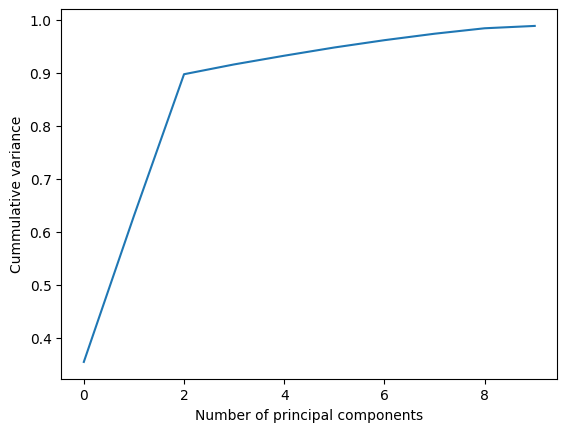

In [9]:
# plotting cummulative variance of n_pcs
plt.plot(fru_pc.results.cumulated_variance[:n_pcs])
plt.xlabel("Number of principal components")
plt.ylabel("Cummulative variance")
plt.show()

In [10]:
# Transforming into reduced space of 2 components
n_pcs = 2
fru_pc_reduced = fru_pc.transform(fru, n_components = n_pcs)

In [11]:
# Making a Pandas dataframe
df = pd.DataFrame(fru_pc_reduced, columns = ["PC{}".format(i+1) for i in range(n_pcs)])
df["Time (ps)"] = u1.trajectory.dt * df.index

In [12]:
ak = df
# append energy as a column
ak["Energy (kJ/mol)"] = ener - min(ener)
# ak["Temperature (K)"] = temp

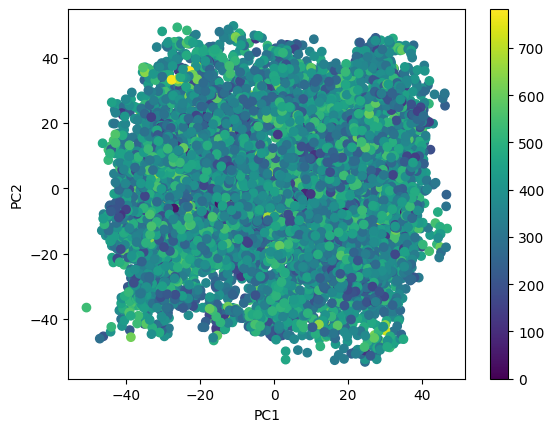

In [13]:
# plot all points in pc1 and pc2 axes with color scale of ener values
plt.scatter(df["PC1"], df["PC2"], c=df["Energy (kJ/mol)"])
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar()
plt.show()

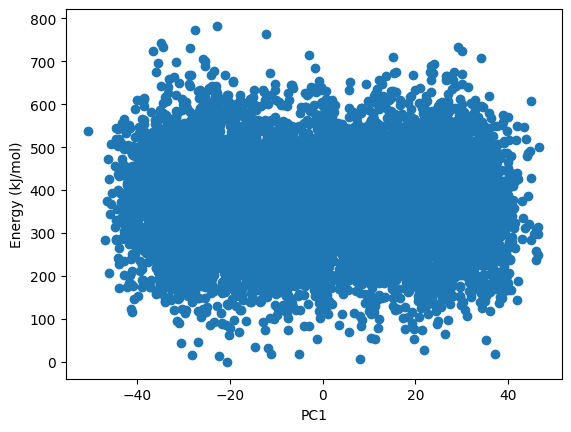

In [14]:
# plot all points in pc1 and ener values
plt.scatter(df["PC1"], df["Energy (kJ/mol)"])
plt.xlabel("PC1")
plt.ylabel("Energy (kJ/mol)")
plt.show()

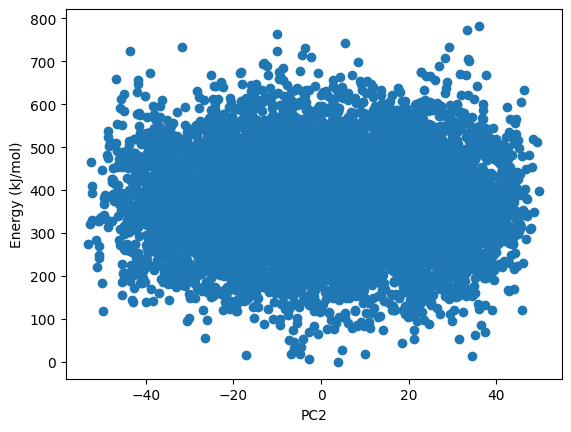

In [15]:
# plot all points in pc2 and ener values
plt.scatter(df["PC2"], df["Energy (kJ/mol)"])
plt.xlabel("PC2")
plt.ylabel("Energy (kJ/mol)")
plt.show()

In [16]:
df.head()

,PC1,PC2,Time (ps),Energy (kJ/mol)
0,14.673906,21.623833,0.0,424.424722
1,12.421385,23.336048,1.0,361.769764
2,10.645819,20.678829,2.0,438.191639
3,10.712614,21.065348,3.0,392.878843
4,11.735998,21.334394,4.0,404.146409


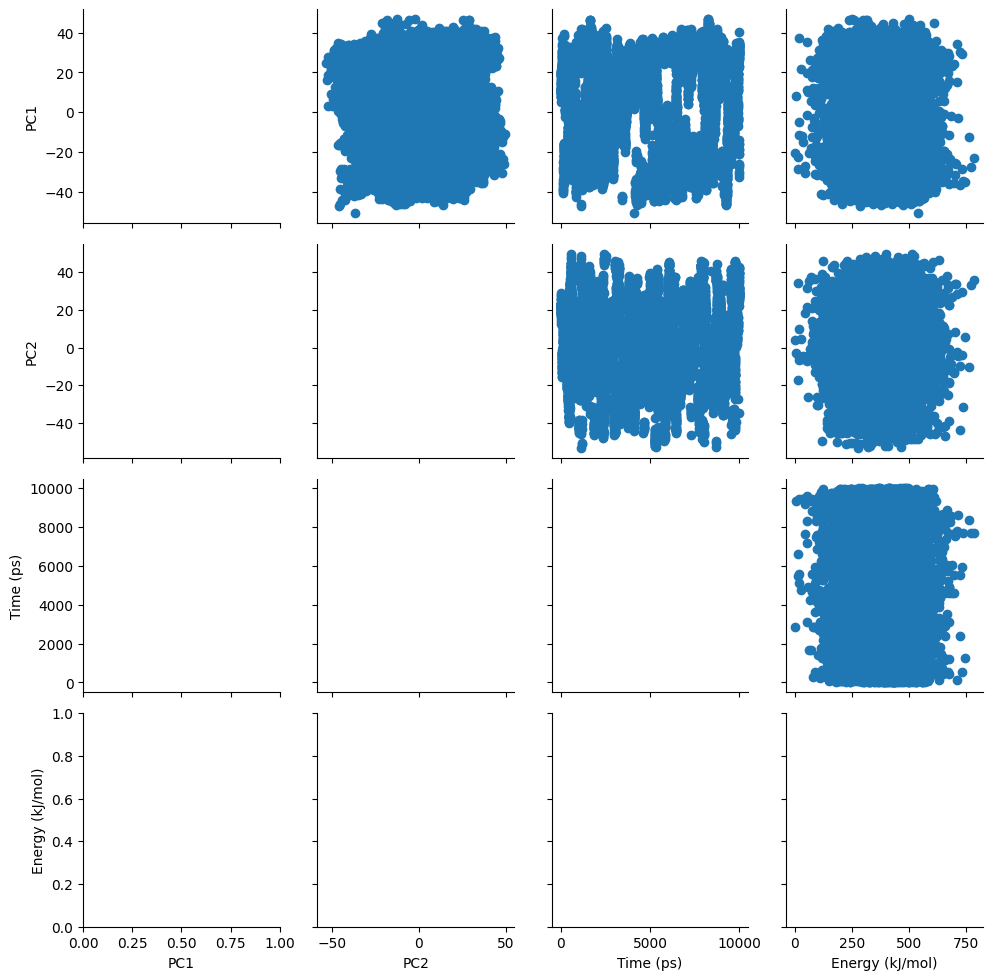

In [17]:
# Visualizing the principal components using seaborn's PairGrid
g = sns.PairGrid(df, diag_sharey=False)
g.map_upper(plt.scatter)
plt.show()

In [18]:
# Measuring convergence with cosine content
cos_content = [pca.cosine_content(fru_pc_reduced, i) for i in range(n_pcs)]

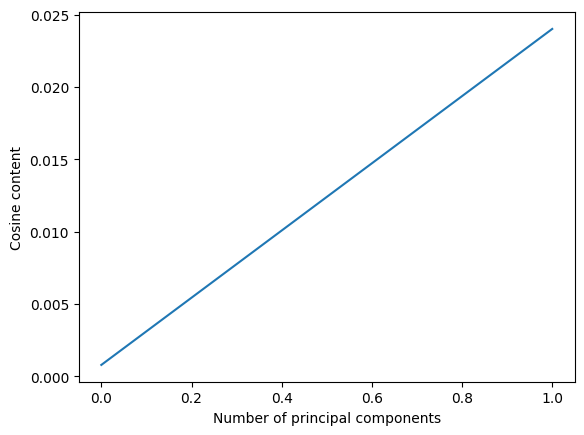

In [19]:
# Plotting the cosine content of each principal components
plt.plot(cos_content)
plt.xlabel("Number of principal components")
plt.ylabel("Cosine content")
plt.show()

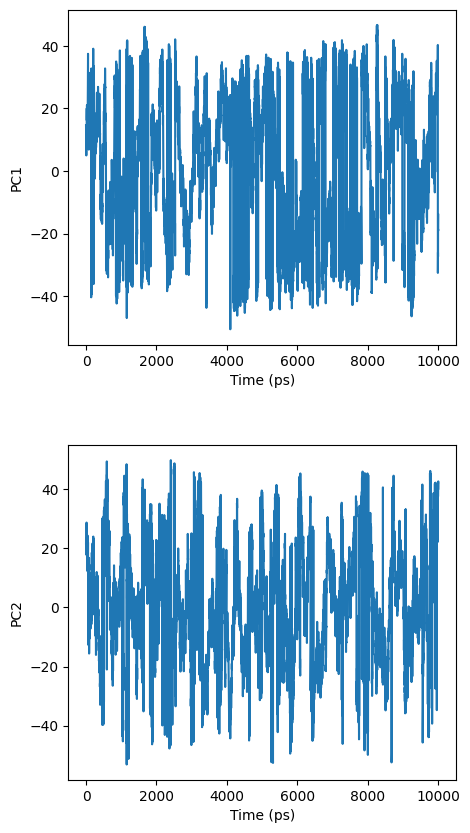

In [20]:
# Plotting transformed components (fru_pc_reduced) over time in different (2 x 1) plots (set both x and y labels and ensure appropriate spacing between plots)
fig, axs = plt.subplots(2, n_pcs // 2, figsize=(5, 10))
fig.subplots_adjust(hspace=0.3, wspace=0.3)
for i in range(n_pcs):
    axs[i].plot(df["Time (ps)"], fru_pc_reduced[:, i])
    axs[i].set_xlabel("Time (ps)")
    axs[i].set_ylabel("PC{}".format(i+1))
plt.show()

In [21]:
#5) Clustering to find patterns in data
#5a) K-Means clustering (plot for 1-xx clusters, plot elbow plot and silhouette score)
# also plot error vs iteration for 10 cluster

# Range of cluster numbers to evaluate
cluster_range = range(2, 61)
inertia_values = []
silhouette_scores = []

# Standardize the data
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df.iloc[:, :-1])

# Perform K-means for each cluster number and compute inertia
for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10, max_iter = 800) # can do a max_iter determination later
    kmeans.fit(df_scaled)
    inertia_values.append(kmeans.inertia_)
    labels = kmeans.labels_
    silhouette_avg = silhouette_score(df, labels)
    silhouette_scores.append(silhouette_avg)

# Create the elbow plot using Plotly
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=list(cluster_range),
    y=inertia_values,
    mode='lines+markers',
    marker=dict(size=8),
    name='Inertia'
))

fig.update_layout(
    title="Elbow Plot for K-Means Clustering",
    xaxis_title="Number of Clusters",
    yaxis_title="Inertia (Sum of Squared Distances)",
    title_x=0.5,
    template="plotly_white"
)

fig.show()

# Create the silhouette plot using Plotly
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=list(cluster_range),
    y=silhouette_scores,
    mode='lines+markers',
    marker=dict(size=8),
    name='Inertia'
))

fig.update_layout(
    title="Silhouette Plot for K-Means Clustering",
    xaxis_title="Number of Clusters",
    yaxis_title="Silhouette Scores)",
    title_x=0.5,
    template="plotly_white"
)

fig.show()

From the Elbow plot we do not see a defined elbow point (joint). Furthermore the silhoette plot has an overall decreasing trend with no maxima, probably suggesting that k-means is not a good algorithm to classify this data

My intuition is since this is MD trajectory data, it will have more sampled configurations in low energy regions, so probably use some density based clustering methods.

Estimated number of clusters: 134
Estimated number of noise points: 3213
['y', 'b', 'g', 'r']


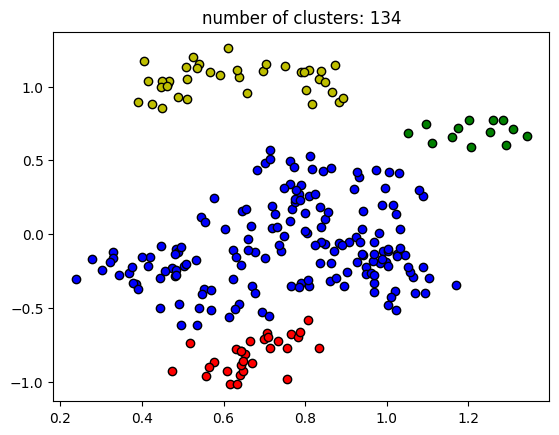

In [22]:
# Using DBSCAN to cluster data
dbscan = DBSCAN(eps=0.135, min_samples=10)
db = dbscan.fit(df_scaled)
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

# plot results

core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = ['y', 'b', 'g', 'r']
print(colors)
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = 'k'

    class_member_mask = (labels == k)

    xy = df_scaled[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
             markeredgecolor='k',
             markersize=6)

    xy = df_scaled[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
             markeredgecolor='k',
             markersize=6)

plt.title('number of clusters: %d' % n_clusters_)
plt.show()

DBSCAN seems to fail too, even after trying a lot of eps, and min_samples parameters

Todo - implement other clustering algorithms (Gaussian Mixture Models, Hierarchial and Spectral Clustering), train supervised learning algorithms, relating structures with energies, interpret the top two PCAs

In [28]:
df.head()

,PC1,PC2,Time (ps),Energy (kJ/mol)
0,14.673906,21.623833,0.0,424.424722
1,12.421385,23.336048,1.0,361.769764
2,10.645819,20.678829,2.0,438.191639
3,10.712614,21.065348,3.0,392.878843
4,11.735998,21.334394,4.0,404.146409


In [39]:
df_new = df
df_new["PC1"] = df_scaled[:, 0]
df_new["PC2"] = df_scaled[:, 1]

cluster_range = range(2, 10)
labels_rbf = []
silhouette_scores = []

# Trying spectral clustering with affinity matrix being Gaussian Kernel
for i in cluster_range:
    spectral_model_rbf = SpectralClustering(n_clusters = i, affinity ='rbf')
    labels_rbf_c = spectral_model_rbf.fit_predict(df_scaled)
    # Training the model and storing the predicted cluster labels
    labels_rbf.append(labels_rbf_c)
    silhouette_c = silhouette_score(df, labels_rbf_c)
    silhouette_scores.append(silhouette_c)

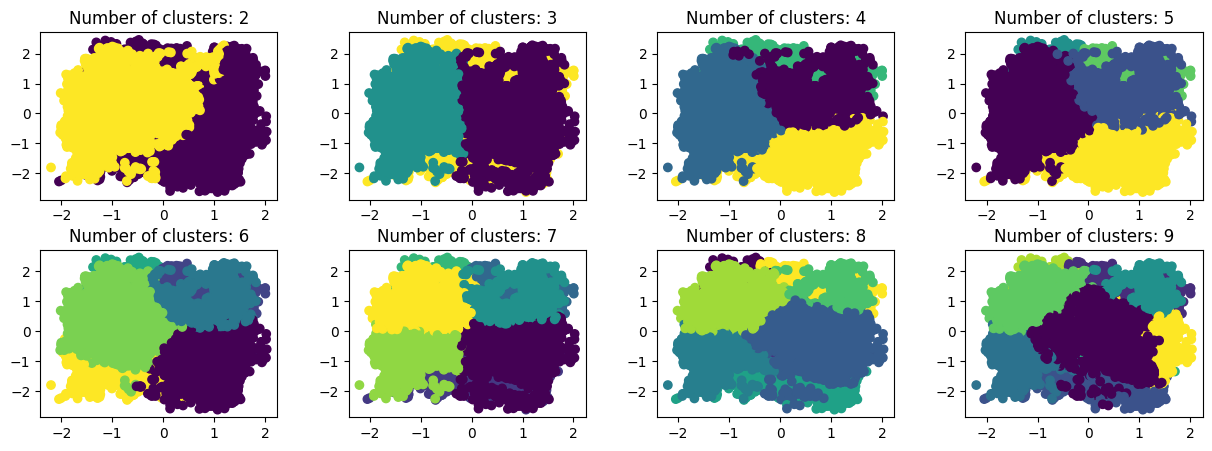

In [43]:
# Plotting the cluster results in separate plots row wise
fig, axs = plt.subplots(2, len(cluster_range) // 2, figsize=(15, 5))
fig.subplots_adjust(hspace=0.3, wspace=0.3)
for i in range(len(cluster_range)):
  if i < 4:
    k = 0
    l = i
  else:
    k = 1
    l = i - 4 * k
  axs[k, l].scatter(df_new['PC1'], df_new['PC2'],
          c = labels_rbf[i])
  axs[k, l].set_title('Number of clusters: {}'.format(cluster_range[i]))
plt.show()

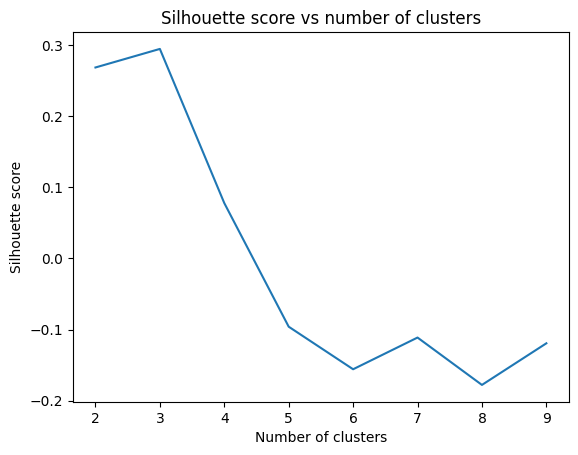

In [45]:
# Plotting silhouette scores and adding axis labels
plt.plot(cluster_range, silhouette_scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.title('Silhouette score vs number of clusters')
plt.show()

Applying Spectral Clustering using the Gaussian Kernal as the "Affintiy" for cluster ranging between 2 to 9, it is observed that cluster size 3 has the highest silhouette score (~0.3). Higher cluster size results in negative silhouette scores suggesting that higher number of clusters result in improper mapping.

In [46]:
labels_nn = []
silhouette_scores_nn = []
for i in cluster_range:
  spectral_model_nn = SpectralClustering(n_clusters = i, affinity ='nearest_neighbors')
  labels_nn_c = spectral_model_nn.fit_predict(df_scaled)
  labels_nn.append(labels_nn_c)
  silhouette_c = silhouette_score(df, labels_nn_c)
  silhouette_scores_nn.append(silhouette_c)

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connect

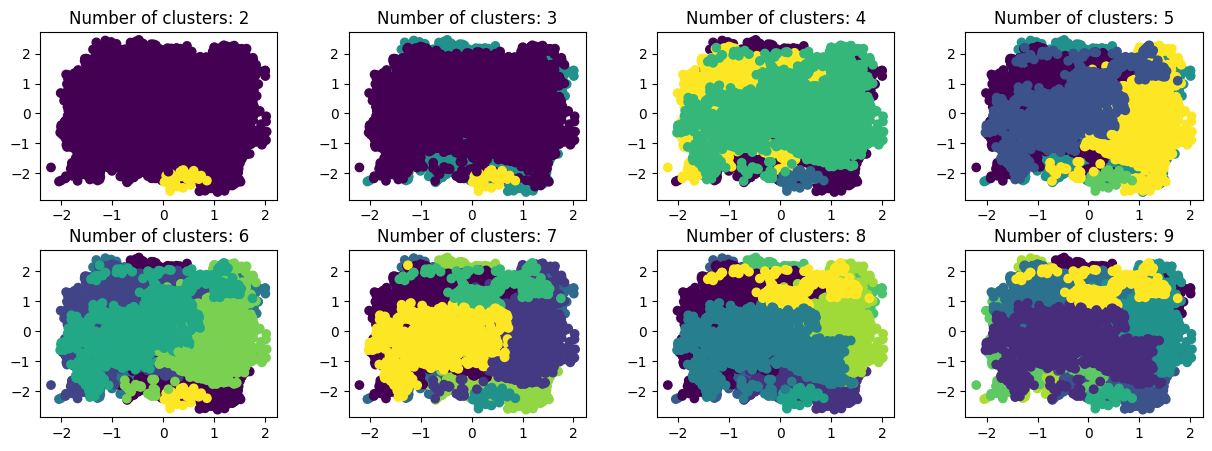

In [47]:
# Plotting the cluster results in separate plots row wise
fig, axs = plt.subplots(2, len(cluster_range) // 2, figsize=(15, 5))
fig.subplots_adjust(hspace=0.3, wspace=0.3)
for i in range(len(cluster_range)):
  if i < 4:
    k = 0
    l = i
  else:
    k = 1
    l = i - 4 * k
  axs[k, l].scatter(df_new['PC1'], df_new['PC2'],
          c = labels_nn[i])
  axs[k, l].set_title('Number of clusters: {}'.format(cluster_range[i]))
plt.show()

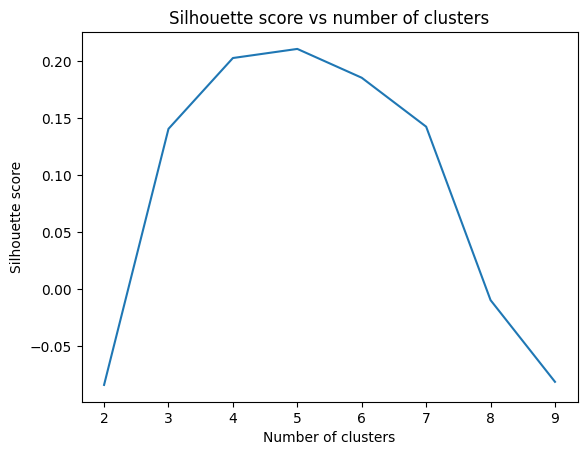

In [48]:
# Plotting silhouette scores and adding axis labels
plt.plot(cluster_range, silhouette_scores_nn)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.title('Silhouette score vs number of clusters')
plt.show()

Using "nearest-neighbors" as the affinity criteria results in a warning that the graph is not fully connected, probably suggesting that "nearest-neighbors" can perform better in situations when the data can be transformed to a fully connected graph. However, ignoring the warning and performing clustering using cluster size range between 2 and 9, we see that cluster size 5 is preferred with the silhouette score being ~0.2. On both sides of cluster 5, the silhouette plot seems to decrease and takes negative values indicating improper mapping.

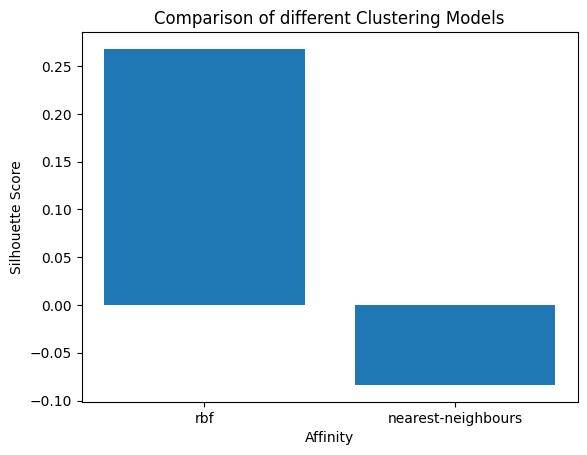

[0.2680487331979044, -0.08366751404707957]


In [36]:
# Performance evaluation
# List of different values of affinity
affinity = ['rbf', 'nearest-neighbours']

# List of Silhouette Scores
s_scores = []

# Evaluating the performance
s_scores.append(silhouette_score(df, labels_rbf))
s_scores.append(silhouette_score(df, labels_nn))

# Plotting a Bar Graph to compare the models
plt.bar(affinity, s_scores)
plt.xlabel('Affinity')
plt.ylabel('Silhouette Score')
plt.title('Comparison of different Clustering Models')
plt.show()

print(s_scores)